## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from robust_what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

In [5]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

## Affichge image MNIST 28x28

In [6]:
transform=transforms.Compose([
                               WhatShift(args, i_offset=None, j_offset=None),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [7]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [8]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [9]:
data, label = next(iter(test_loader))

Text(0.5, 1.0, 'label : 8')

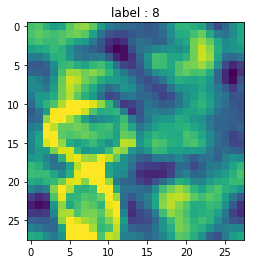

In [10]:
i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))

## Affichage Image 128x128

In [6]:
import sys
sys.path.append("../figures")

from where_copie import RetinaFill, RetinaBackground, RetinaMask, RetinaWhiten 

In [7]:
i_offset = None
j_offset = None

In [8]:
from display import minmax

class WhereShift:
    def __init__(self, args, i_offset=None, j_offset=None, radius=None, theta=None, baseline=0., keep_label = False):
        self.args = args
        self.i_offset = i_offset
        self.j_offset = j_offset
        self.radius = radius
        self.theta = theta
        self.baseline = baseline
        self.keep_label = keep_label

    def __call__(self, data):
        #sample = np.array(sample)
        
        sample = data[0]
        seed = data[1]
        if self.keep_label:
            label = data[2]
        
        #print(index)
        np.random.seed(seed)
        
        if self.i_offset is not None:
            i_offset = self.i_offset
            if self.j_offset is None:
                #j_offset_f = np.random.randn() * self.args.offset_std
                #j_offset_f = minmax(j_offset_f, self.args.offset_max)
                #j_offset = int(j_offset_f)
                j_offset = np.random.randint( - self.args.offset_max, self.args.offset_max)
            else:
                j_offset = int(self.j_offset)
        else: 
            if self.j_offset is not None:
                j_offset = int(self.j_offset)
                #i_offset_f = np.random.randn() * self.args.offset_std
                #i_offset_f = minmax(i_offset_f, self.args.offset_max)
                #i_offset = int(i_offset_f)
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
            else: #self.i_offset is None and self.j_offset is None
                i_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                j_offset = np.random.randint( - self.args.N_pic //3, self.args.N_pic //3)
                """
                if self.theta is None:
                    theta = np.random.rand() * 2 * np.pi
                    #print(theta)
                else:
                    theta = self.theta
                if self.radius is None:
                    radius_f = np.abs(np.random.randn()) * self.args.offset_std
                    radius = minmax(radius_f, self.args.offset_max)
                    #print(radius)
                else:
                    radius = self.radius
                i_offset = int(radius * np.cos(theta))
                j_offset = int(radius * np.sin(theta))
                """
                
        #print("i_offset = ", i_offset)
        #print("j_offset = ", j_offset)
                
        N_pic = sample.shape[0]
        fullfield = np.ones((N_pic, N_pic)) * self.baseline
        i_binf_patch = max(0, -i_offset)
        i_bsup_patch = min(N_pic, N_pic - i_offset)
        j_binf_patch = max(0, -j_offset)
        j_bsup_patch = min(N_pic, N_pic - j_offset)
        patch = sample[i_binf_patch:i_bsup_patch,
                       j_binf_patch:j_bsup_patch]

        i_binf_data = max(0, i_offset)
        i_bsup_data = min(N_pic, N_pic + i_offset)
        j_binf_data = max(0, j_offset)
        j_bsup_data = min(N_pic, N_pic + j_offset)
        fullfield[i_binf_data:i_bsup_data,
                  j_binf_data:j_bsup_data] = patch
        if self.keep_label:
            return fullfield, label, i_offset, j_offset
        else:
            return fullfield #.astype('B')

In [9]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               #RetinaWhiten(N_pic=args.N_pic),
                                #OnlineRetinaTransform(retina) # ç décommenter une fois que le code sera mieux écrit
                               #RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [10]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [11]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [12]:
data3, label3 = next(iter(test_loader))

In [13]:
print(data3.shape)
label3.shape

torch.Size([100, 128, 128])


torch.Size([100])

shape torch.Size([100, 128, 128])


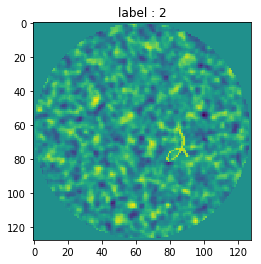

In [14]:
i=7
plt.imshow(data3[i])
print('shape',data3[:,:].shape)
plt.title('label : '+str(label3[i].item()))

if False :
    plt.savefig("image128x128")

In [15]:
#plt.plot(data3[i].detach().numpy())
#plt.plot(data3[i,:,:])
print(data3[i])

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       dtype=torch.float64)


## Essai

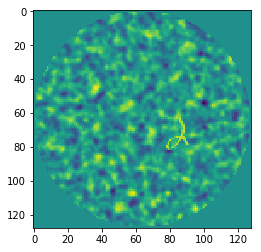

In [16]:
pixel_fullfield = data3[i]
plt.imshow(pixel_fullfield)
#plt.imshow(pixel_fullfield[0:50,0:50])

0.7770922496500585
1.0957000720065824
1.5449371015292812
2.178361313156287
3.0714894515503643
4.330800126686012
6.106428178627277
8.610063731864463
12.140189861928889
17.117667705319736


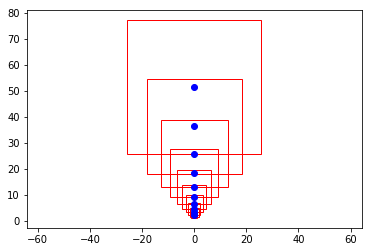

In [17]:
import matplotlib.patches as patches

ecc_max = 0.8
N_X, N_Y = 128, 128

Essai_r = []

fig, ax = plt.subplots()
for i_eccentricity in range(args.N_eccentricity):   
    Essai_ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    Essai_r.append(np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * Essai_ecc)  # radius

ax.plot([0]*10,Essai_r,'o', color='b')
    
    
for i in range(len(Essai_r)) :
    #rect = patches.Rectangle((-Essai_r[i]**(1/2)/2, Essai_r[i]-Essai_r[i]**(1/2)/2),Essai_r[i]**(1/2),Essai_r[i]**(1/2),linewidth=1,edgecolor='r',facecolor='none')
    rect = patches.Rectangle((-Essai_r[i]/2, Essai_r[i]-Essai_r[i]/2),Essai_r[i],Essai_r[i],linewidth=1,edgecolor='r',facecolor='none')
    #rect = patches.Rectangle((-Essai_r[i]/6, Essai_r[i]-Essai_r[i]/6),Essai_r[i]/3,Essai_r[i]/3,linewidth=1,edgecolor='r',facecolor='none')
    print(Essai_r[i]/3)
    ax.add_patch(rect)

ax.set_xlim((-5, 15))
ax.set_ylim((0, 10))
plt.axis("equal")
plt.show()

In [18]:
import matplotlib.patches as patches
from display import pe

# code original au self pres

def online_vectorization(pixel_fullfield):   # pixel_fullfield = image
        fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

        from LogGabor import LogGabor
        lg = LogGabor(pe=pe)
        lg.set_size((args.N_pic, args.N_pic))
        
        indice = 0
        for i_theta in range(args.N_theta):
            for i_azimuth in range(args.N_azimuth):
                for i_eccentricity in range(args.N_eccentricity):
                    for i_phase in range(args.N_phase):
                        filter = local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                                  N_Y=args.N_pic)
                        fullfield_dot_filters[indice] = np.dot(np.ravel(filter), np.ravel(pixel_fullfield))
                        indice += 1

        return fullfield_dot_filters

In [19]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des zeros

def online_vectorization_zeros(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    
    indice = 0
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                        #print(filter.shape)
                        #fig, ax = plt.subplots()
                        #plt.imshow(filter)
                        #plt.title("filtre")
                        #rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
                        #ax.add_patch(rect)
                        #plt.show()
                    #print("taille et positions filtre",size,x,y)
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    #print("filter", np.ravel(fenetre_filtre).shape)
                    
                    if size%2 ==0 :
                        #print(x-size/2,y-size/2)
                        #print("x,y,r",x,y,r)
                        #print(int(x-r),int(x+r),int(y-r),int(y+r))
                        fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                        #print("image1", np.ravel(fenetre_image).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image)
                            #plt.title("image1")
                            #plt.show()
                        if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                            #print("tailles differentes")
                            complement = [0]*(np.ravel(fenetre_filtre).shape[0] - np.ravel(fenetre_image).shape[0])
                            #print("extrait filtre", fenetre_filtre[0:20])
                            #print("extrait image", fenetre_image[0:20])
                            #print("extrait complement", complement[0:20])
                            fenetre_image = np.concatenate((np.ravel(fenetre_image), complement))
                            #print("image1", np.ravel(fenetre_image).shape)
                        a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                        #a=0
                        fullfield_dot_filters[indice] = a
                        
                    else :
                        fenetre_image2 = pixel_fullfield[x-int(r)-1:x+int(r),y-int(r)-1:y+int(r)]
                        #print("image2", np.ravel(fenetre_image2).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image2)
                            #plt.title("image2")
                            #plt.show()
                        if np.ravel(fenetre_image2).shape != np.ravel(fenetre_filtre).shape :
                            complement = [0]*(np.ravel(fenetre_filtre).shape[0] - np.ravel(fenetre_image).shape[0])
                            fenetre_image = np.concatenate((np.ravel(fenetre_image), complement))                            
                        b = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image2))
                        #b=0
                        fullfield_dot_filters[indice] = b
                    
                    indice += 1
                    #print("\n")

    return fullfield_dot_filters

In [24]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des vraies valeurs, damier 3x3


def online_vectorizationV(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    
    indice = 0 
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    #r = min(2*r, 128)
                    r = min(2*r, 64)
                    #r = min(1.5, 64)
                    #print(r)
                    #print("filter", np.ravel(filter).shape)
                    filter -= np.mean(filter)
                    if True and i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                        print(filter.shape)
                        fig, ax = plt.subplots()
                        plt.imshow(filter)
                        plt.title("filtre")
                        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)
                        plt.show()
                    #print("taille et positions filtre",size,x,y)
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    #print("fenetre filter", np.ravel(fenetre_filtre).shape)
                    #print("len fenetre filter", int(args.N_pic//2-r)-int(args.N_pic//2+r), int(args.N_pic//2-r)-int(args.N_pic//2+r))
                    
                    
                    if size%2 ==0 :
                        #print(x-size/2,y-size/2)
                        #print("x,y,r",x,y,r)
                        #print(int(x-r),int(x+r),int(y-r),int(y+r))
                        fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                        #print("fenetre image1", np.ravel(fenetre_image).shape)
                        #print("len fenetre image1", int(x-r)-int(x+r), int(y-r)-int(y+r))
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image)
                            #plt.title("image1")
                            #plt.show()
                        if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                            #print("tailles differentes")
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            #plt.imshow(image_agrandie)
                            #plt.title("image agrandie")
                            #plt.show()
                            fenetre_image = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic +y-r) : int(args.N_pic +y+r)]
                            #plt.imshow(fenetre_image)
                            #plt.title("fenetre_redimensionnee")
                            #plt.show()
                            #print("filter", np.ravel(fenetre_filtre).shape)
                            #print("fenetre image", np.ravel(fenetre_image).shape)
                            #print("x,y,r",x,y,r)
                        #print("i_theta, i_azimuth, i_eccentricity, i_phase", i_theta, i_azimuth, i_eccentricity, i_phase)
                        a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                        #a=0
                        fullfield_dot_filters[indice] = a
                        
                    else :
                        fenetre_image2 = pixel_fullfield[int(x-r-1):int(x+r),int(y-r-1):int(y+r)]
                        #print("image2", np.ravel(fenetre_image2).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image2)
                            #plt.title("image2")
                            #plt.show()
                        if np.ravel(fenetre_image2).shape != np.ravel(fenetre_filtre).shape :
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            #print("image agrandie")
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            fenetre_image2 = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic + y-r) : int(args.N_pic + y+r)]                              
                        #print("filter", np.ravel(fenetre_filtre).shape)
                        #print("fenetre image2", np.ravel(fenetre_image2).shape)
                        #print("x,y,r",x,y,r)
                        b = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image2))
                        #b=0
                        fullfield_dot_filters[indice] = b
                    indice += 1
                    
                    
                    #print("\n")

    return fullfield_dot_filters

In [ ]:
import matplotlib.patches as patches
from display import pe

## Completion image avec des vraies valeurs, modulo


def online_vectorizationVm(pixel_fullfield):   # pixel_fullfield = image # on enleve self pour l'instant
    fullfield_dot_filters = np.zeros(args.N_theta * args.N_azimuth * args.N_eccentricity * args.N_phase)

    from LogGabor import LogGabor
    lg = LogGabor(pe=pe)
    
    indice = 0 
    for i_theta in range(args.N_theta):
        for i_azimuth in range(args.N_azimuth):
            for i_eccentricity in range(args.N_eccentricity):
                for i_phase in range(args.N_phase):
                    filter, size, x, y, r = local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg, N_X=args.N_pic,
                                              N_Y=args.N_pic)
                    #r = min(2*r, 128)
                    r = min(2*r, 64)
                    #r = min(1.5, 64)
                    #print(r)
                    #print("filter", np.ravel(filter).shape)
                    filter -= np.mean(filter)
                    if True and i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                        print(filter.shape)
                        fig, ax = plt.subplots()
                        plt.imshow(filter)
                        plt.title("filtre")
                        rect = patches.Rectangle((args.N_pic//2-r, args.N_pic//2-r), 2*r, 2*r,linewidth=3,edgecolor='r',facecolor='none')
                        ax.add_patch(rect)
                        plt.show()
                    #print("taille et positions filtre",size,x,y)
                    fenetre_filtre = filter[int(args.N_pic//2-r):int(args.N_pic//2+r),int(args.N_pic//2-r):int(args.N_pic//2+r)]
                    #print("fenetre filter", np.ravel(fenetre_filtre).shape)
                    #print("len fenetre filter", int(args.N_pic//2-r)-int(args.N_pic//2+r), int(args.N_pic//2-r)-int(args.N_pic//2+r))
                    
                    
                    if size%2 ==0 :
                        #print(x-size/2,y-size/2)
                        #print("x,y,r",x,y,r)
                        #print(int(x-r),int(x+r),int(y-r),int(y+r))
                        fenetre_image = pixel_fullfield[int(x-r):int(x+r),int(y-r):int(y+r)]
                        #print("fenetre image1", np.ravel(fenetre_image).shape)
                        #print("len fenetre image1", int(x-r)-int(x+r), int(y-r)-int(y+r))
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image)
                            #plt.title("image1")
                            #plt.show()
                        if np.ravel(fenetre_image).shape != np.ravel(fenetre_filtre).shape :
                            #print("tailles differentes")
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            #plt.imshow(image_agrandie)
                            #plt.title("image agrandie")
                            #plt.show()
                            fenetre_image = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic +y-r) : int(args.N_pic +y+r)]
                            #plt.imshow(fenetre_image)
                            #plt.title("fenetre_redimensionnee")
                            #plt.show()
                            #print("filter", np.ravel(fenetre_filtre).shape)
                            #print("fenetre image", np.ravel(fenetre_image).shape)
                            #print("x,y,r",x,y,r)
                        #print("i_theta, i_azimuth, i_eccentricity, i_phase", i_theta, i_azimuth, i_eccentricity, i_phase)
                        a = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image))
                        #a=0
                        fullfield_dot_filters[indice] = a
                        
                    else :
                        fenetre_image2 = pixel_fullfield[int(x-r-1):int(x+r),int(y-r-1):int(y+r)]
                        #print("image2", np.ravel(fenetre_image2).shape)
                        #if i_azimuth == 0 and i_theta == 0 and i_phase == 0 :
                            #plt.imshow(fenetre_image2)
                            #plt.title("image2")
                            #plt.show()
                        if np.ravel(fenetre_image2).shape != np.ravel(fenetre_filtre).shape :
                            image_agrandie = np.zeros((3*args.N_pic,3*args.N_pic))
                            #print("image agrandie")
                            for i in range(3):
                                for j in range(3):
                                    image_agrandie[i*args.N_pic : (i+1)*args.N_pic , j*args.N_pic : (j+1)*args.N_pic] = pixel_fullfield
                            fenetre_image2 = image_agrandie[int(args.N_pic + x-r) : int(args.N_pic+ x+r), int(args.N_pic + y-r) : int(args.N_pic + y+r)]                              
                        #print("filter", np.ravel(fenetre_filtre).shape)
                        #print("fenetre image2", np.ravel(fenetre_image2).shape)
                        #print("x,y,r",x,y,r)
                        b = np.dot(np.ravel(fenetre_filtre), np.ravel(fenetre_image2))
                        #b=0
                        fullfield_dot_filters[indice] = b
                    indice += 1
                    
                    
                    #print("\n")

    return fullfield_dot_filters

In [21]:
## code original au self pres

def local_filter(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12):

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi)
    y = N_Y / 2 + r * np.sin(psi)
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    return lg.normalize(lg.invert(lg.loggabor(x, y, **params) * np.exp(-1j * phase))).ravel()


In [22]:
def local_filter2(i_theta, i_azimuth, i_eccentricity, i_phase, lg,
                 N_X=128, N_Y=128):
                 #rho=1.41, ecc_max=.8,
                 #sf_0_max=0.45, sf_0_r=0.03,
                 #B_sf=.4, B_theta=np.pi / 12): # on enleve self pour l'instant

    # !!?? Magic numbers !!??
    ecc_max = .8 # self.args.ecc_max
    sf_0_r = 0.03 # self.args.sf_0_r
    B_theta = np.pi/args.N_theta/2 #self.args.B_theta
    B_sf = .4
    sf_0_max = 0.45

    ecc = ecc_max * (1 / args.rho) ** (args.N_eccentricity - i_eccentricity)
    r = np.sqrt(N_X ** 2 + N_Y ** 2) / 2 * ecc  # radius
    #print(r)
    size = int(2*r)
    if size < 2 :
        size = 2    
    #print("size",size)
    #lg.set_size((size, size))
    lg.set_size((N_X, N_Y))
    # psi = i_azimuth * np.pi * 2 / N_azimuth
    psi = (i_azimuth + 1 * (i_eccentricity % 2) * .5) * np.pi * 2 / args.N_azimuth
    theta_ref = i_theta * np.pi / args.N_theta
    sf_0 = 0.5 * sf_0_r / ecc
    sf_0 = np.min((sf_0, sf_0_max))
    # TODO : find the good ref for this                print(sf_0)
    x = N_X / 2 + r * np.cos(psi) # c'est bien le centre du filtre ?
    y = N_Y / 2 + r * np.sin(psi) # c'est bien le centre du filtre ?
    params = {'sf_0': sf_0,
              'B_sf': B_sf,
              'theta': theta_ref + psi,
              'B_theta': B_theta}
    phase = i_phase * np.pi / 2
    #lg.show_loggabor(x, y, **params)
    #print('taille sortie', lg.loggabor(x, y, **params).ravel().shape)
    return lg.normalize(lg.invert(lg.loggabor(N_X//2, N_Y//2, **params) * np.exp(-1j * phase))), size, int(x), int(y), r

(128, 128)


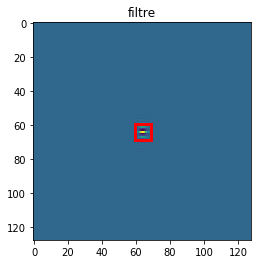

(128, 128)


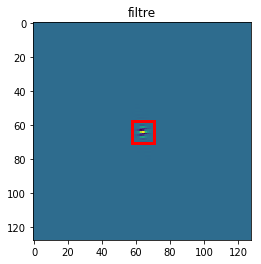

(128, 128)


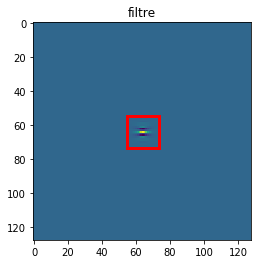

(128, 128)


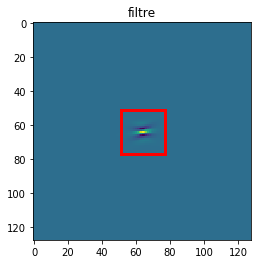

(128, 128)


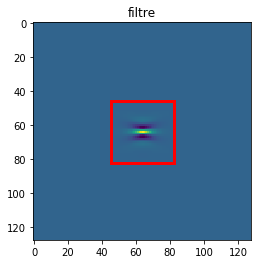

(128, 128)


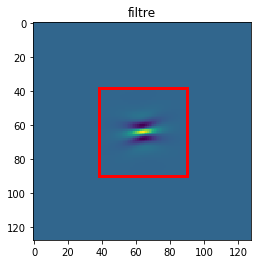

(128, 128)


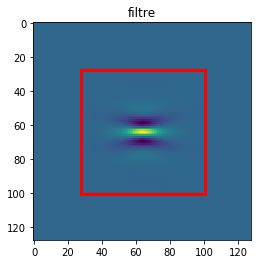

(128, 128)


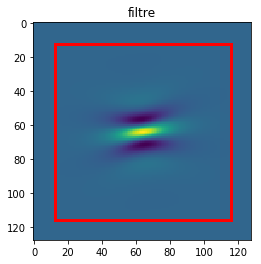

(128, 128)


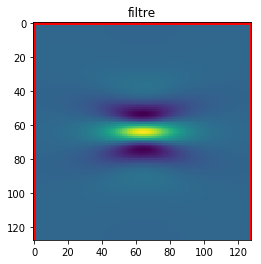

(128, 128)


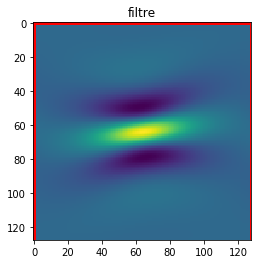

In [25]:
fullfield_dot_filtersV = online_vectorizationV(pixel_fullfield)

In [26]:
fullfield_dot_filters = online_vectorization(pixel_fullfield)
fullfield_dot_filters0 = online_vectorization_zeros(pixel_fullfield)

Ci-dessous, compléter l'image avec des zéros ne donne pas de bons résultats (courbe verte très éloignée de courbe rouge).

En décommentant les 2 dernières lignes, compléter l'image avec des bouts d'image fonctionne bien avec r=min(2r,64) (courbe bleue proche de courbe rouge)


(-25, 25)

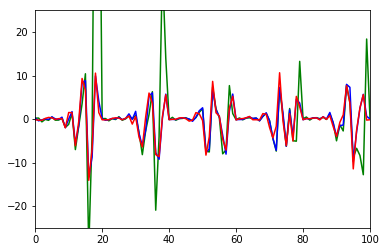

In [31]:
plt.plot(fullfield_dot_filters0, 'g')
plt.plot(fullfield_dot_filtersV, 'b')
plt.plot(fullfield_dot_filters,'r')

axes = plt.gca()
#axes.set_xlim(0,100)
#axes.set_ylim(-25,25)


In [33]:
indice =0
nb=0
minrouge = min(fullfield_dot_filters)
for i in fullfield_dot_filtersV:
    if i<minrouge-1:
        print(indice)
        nb+=1
    indice+=1
print(nb/indice)

0.0
